<a href="https://colab.research.google.com/github/venkii83/Springboard/blob/master/DL_First_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2

In [3]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [0]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [0]:
np.random.seed(2019)
tf.random.set_seed(2019)
SEED=2019

In [6]:
from google.colab import files
df1 = files.upload()

Saving train.csv to train.csv


In [7]:
from google.colab import files
df2 = files.upload()

Saving test.csv to test.csv


In [0]:
import io
train_df = pd.read_csv(io.BytesIO(df1['train.csv']))
test_df = pd.read_csv(io.BytesIO(df2['test.csv']))
# Dataset is now stored in a Pandas Dataframe

In [8]:
test_df.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [10]:
print(train_df.shape)
print(test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

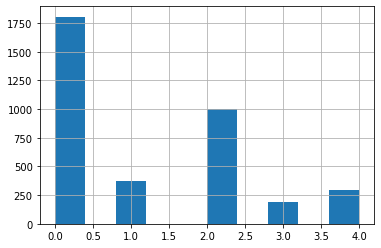

In [0]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

In [0]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Training features; Let's loop through the training and test data and grab some summary statistics about the images:
#Height
#Width
#Height to Width Ratio
#Total Number of Pixels
#Total Number of Black Pixels 
#Total Proportion of Black Pixels
#Channel Means

train_results = []

for index, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
    img = cv2.imread('/content/gdrive/My Drive/SPRINGBOARD/Blindness Detect/train_images/{}.png'.format(row['id_code']))

    height, width, channels = img.shape
    ratio = width/height
    pixel_count = width*height
    gray_scaled = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    black_cnt = pixel_count-cv2.countNonZero(gray_scaled)
    black_pct = black_cnt/pixel_count
    mean0, mean1, mean2, _ = cv2.mean(img)

    observation = np.array(
        (row['diagnosis'], height, width, ratio, pixel_count, black_cnt, black_pct, mean0, mean1, mean2))

    train_results.append(observation)

train_results_df = pd.DataFrame(train_results)
train_results_df.columns = [
    'diagnosis','height','width','ratio','pixel_count','black_cnt','black_pct','mean_c0','mean_c1','mean_c2']

100%|██████████| 3662/3662 [38:11<00:00,  1.36it/s]


# Basic Model to see feature importance and calcuate a initial Kappa score:

*The Kappa coefficient is a chance-adjusted index of agreement. In machine learning it can be used to quantify the amount of agreement between an algorithm's predictions and some trusted labels of the same objects; it then attempts to adjust for the probability of the algorithm and trusted labels assigning items to the same category "by chance. Chance-adjusted indices estimate the amount of agreement between raters that can be expected to have occurred due to chance (i.e., random guessing)."*

In [0]:
params = {
    'booster': 'gbtree',
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'eta': 0.005,
    'max_depth': 10,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'tree_method': 'gpu_hist',
    'num_class': 5}

In [0]:
X = train_results_df.drop(columns=['diagnosis'])
y = train_results_df['diagnosis']
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100000,
    evals=watchlist,
    early_stopping_rounds=250,
    verbose_eval=100)

In [0]:
pred = pd.DataFrame(np.argmax(bst.predict(dvalid), axis=1))
results = pd.concat([y_test.reset_index(drop=True), pred], axis=1)
score = cohen_kappa_score(results.iloc[:,0], results.iloc[:,1], weights="quadratic")

print('Validation Kappa:', score)

Validation Kappa: 0.704344795331393


[Text(33.0, 0.5, 'True label'), Text(0.5, 15.0, 'Predicted label')]

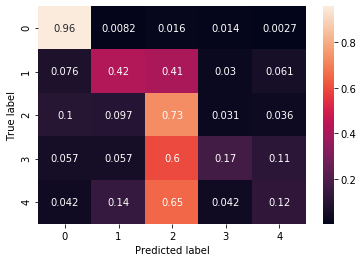

In [0]:
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_true=results.iloc[:,0], y_pred=results.iloc[:,1])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True)
ax.set(ylabel='True label', xlabel='Predicted label')

#A Kappa score of 70% denotes that the ML classifier is accurate 7/10 times compared to the observed accuracy however the confusion matrix shows that the accurate prediction is primarily concentrated between classes 0, 1 and 2; the below analysis validates the same.

In [0]:
train_df['diagnosis'].value_counts()/train_df.shape[0]

0    0.492900
2    0.272802
1    0.101038
4    0.080557
3    0.052703
Name: diagnosis, dtype: float64

Let's look at the feature importance 

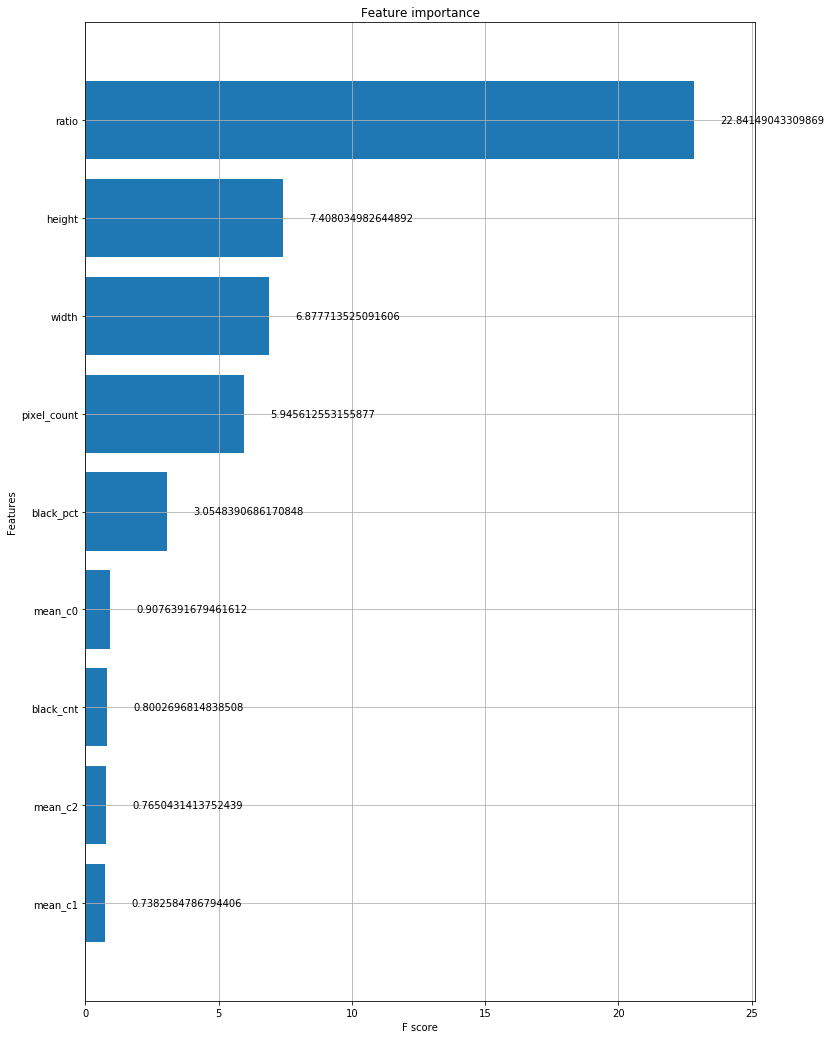

In [0]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(bst, importance_type='gain', height=0.8, ax=ax)

The Ratio along with height, width and pixel count seems to be the top four features.

In [0]:
train_results_df.groupby(['ratio', 'diagnosis'])['pixel_count'].count()

ratio     diagnosis
1.000000  0.0          901
          1.0           19
          2.0           39
          3.0            2
          4.0           13
1.216553  3.0            1
1.309119  1.0           13
          2.0           91
          3.0            6
          4.0           31
1.321397  0.0           10
          3.0            2
          4.0            2
1.321622  2.0            2
1.321757  0.0          231
          1.0           44
          2.0          165
          3.0           47
          4.0           46
1.324022  2.0            1
          4.0            1
1.333333  0.0          351
          2.0           33
          3.0            5
          4.0            4
1.333876  0.0          279
          1.0            7
          2.0            1
1.391705  0.0           31
          1.0          234
          2.0          233
          3.0           60
          4.0           80
1.489712  1.0            6
          2.0            3
          3.0           21
        

*One of the observations based on the above analysis is that square images are almost always equal to class Zero & higher ratios points out in the direction of higher classes. This clearly asks for a standardization & resizing of the images. However we would want to run a CNN on the existing images*

In [0]:
# Function to show few images
def plot_img(img, target_dir, class_label='0'):
    fig, axis = plt.subplots(2, 6, figsize=(15, 6))
    #enumerate for getting row or column line by line.
    for idnx, (idx, row) in enumerate(img.iterrows()):
        img = cv2.imread('/content/gdrive/My Drive/SPRINGBOARD/Blindness Detect/train_images/{}.png'.format(row['id_code']))
        row = idnx // 6
        col = idnx % 6
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axis[row, col].imshow(img)
    plt.suptitle(class_label)
    plt.show()

In [0]:
CLASS = {0: "No DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferative DR"}

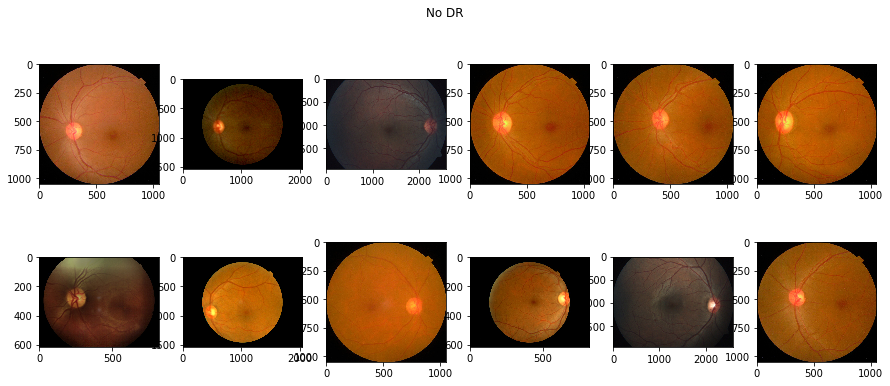

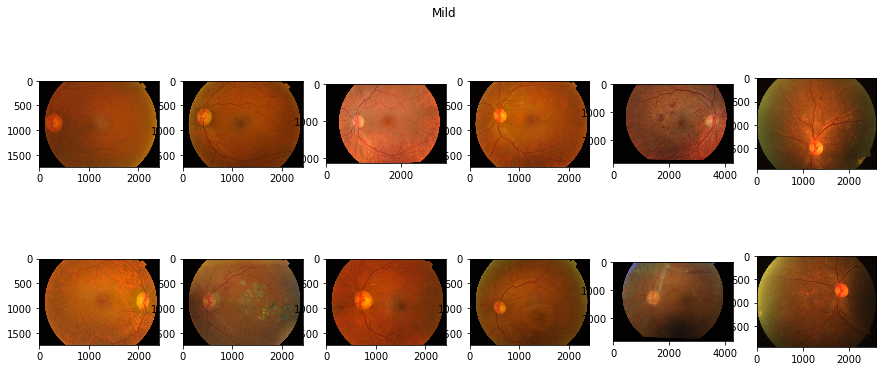

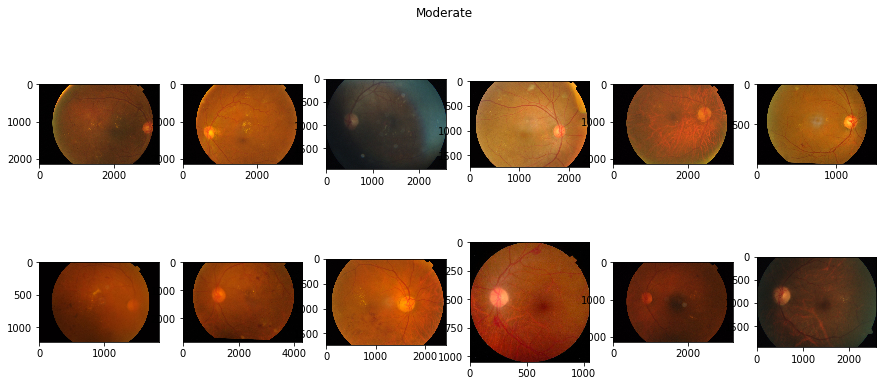

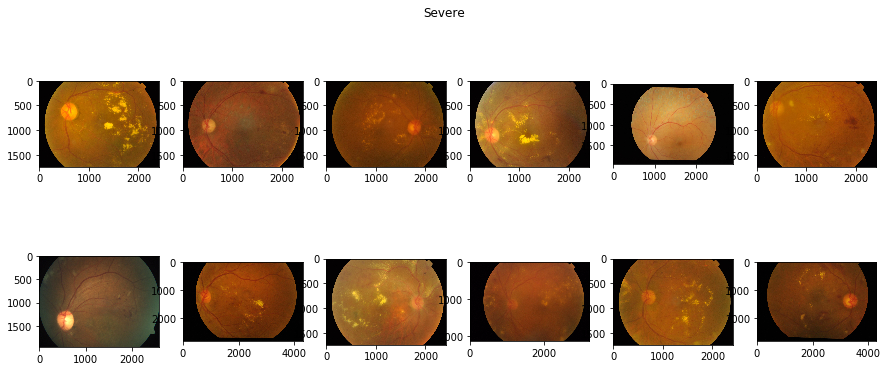

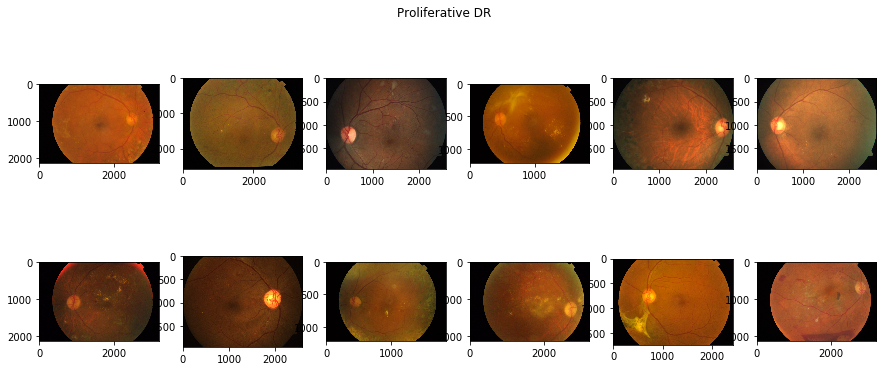

In [0]:
CLASS_ID = 0
plot_img(train_df[train_df.diagnosis == CLASS_ID].head(12), 'train_images', CLASS[CLASS_ID])

CLASS_ID = 1
plot_img(train_df[train_df.diagnosis == CLASS_ID].head(12), 'train_images', CLASS[CLASS_ID])

CLASS_ID = 2
plot_img(train_df[train_df.diagnosis == CLASS_ID].head(12), 'train_images', CLASS[CLASS_ID])

CLASS_ID = 3
plot_img(train_df[train_df.diagnosis == CLASS_ID].head(12), 'train_images', CLASS[CLASS_ID])

CLASS_ID = 4
plot_img(train_df[train_df.diagnosis == CLASS_ID].head(12), 'train_images', CLASS[CLASS_ID])

We can clearly see in the image [0,1], [0,4], [0,3] there are black dots around the eye ball; this can increase the noise in the data, Also pls look at blank spaces in images [4,3],[3, 4] &
[2,3] which will make it difficult for the model to classify images with accuracy.

In [0]:
#Split training data set
SEED=10
x_train, x_test, y_train, y_test = train_test_split(train_df.id_code, train_df.diagnosis, test_size=0.2,
                                                    random_state=SEED, stratify=train_df.diagnosis)

In [0]:
import os
os.environ['OPENCV_IO_MAX_IMAGE_PIXELS']=str(2**64)
import cv2 

In [13]:
#The above images validate our claim that the images are not in standard shape, we need to resize data set image but prior to that we should convert the images to grayscale in order
# to identify 'region of interest'.
IMG_DIM = 250
figure = plt.figure(figsize=(20, 16))
for target_class in (y_train.unique()):
    for i, (idx, row) in enumerate(
            train_df.loc[train_df.diagnosis == target_class].sample(5, random_state=SEED).iterrows()):
        img ='/content/gdrive/My Drive/SPRINGBOARD/Blindness Detect/train_images/{}.png'
        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        img = cv2.resize(img, (IMG_DIM, IMG_DIM))
        plt.imshow(img, cmap='gray')
        ax.set_title(CLASSS[target_class])

error: ignored

<Figure size 1440x1152 with 0 Axes>

We can clearly see in the image [0,1], [0,4], [0,3] there are black dots around the eye ball; this can increase the noise in the data, Also pls look at blank spaces in images [4,3],[3, 0] & [2,3] 
which will make it difficult for the model to classify images with accuracy.

In [0]:
train_df['diagnosis'] = train_df['diagnosis'].astype('str')
train_df['id_code'] = train_df['id_code'].astype(str)+'.png'

In [14]:
train_df.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [146]:
train_data = np.arange(train_df.shape[0])
train_idx, test_idx = train_test_split(train_data, train_size=0.25, random_state=2019)

train_data = np.arange(train_df.shape[0])
train_idx, val_idx = train_test_split(train_data, train_size=0.75, random_state=2019)

X_train = train_df.iloc[train_idx, :]
X_val = train_df.iloc[val_idx, :]
X_test = train_df.iloc[test_idx, :]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2746, 2)
(916, 2)
(2747, 2)


In [0]:
from tensorflow import keras

In [0]:
#Resizing the images for running a CNN:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

num_classes = 5
img_size = (128, 128, 3)
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
nb_test_samples = len(X_test)
epochs = 50
batch_size = 256

train_datagen = ImageDataGenerator(
  horizontal_flip=True,
  vertical_flip=True,
  width_shift_range=0.1,
  height_shift_range=0.1,
  brightness_range=[0.5, 1.5],
  rescale=1./255
)
val_datagen = ImageDataGenerator(
  rescale=1./255
)
# Apply TTA
test_datagen = ImageDataGenerator(
  rescale=1./255
)

In [149]:
train_generator = train_datagen.flow_from_dataframe(
  dataframe=X_train, 
  directory="../content/gdrive/My Drive/SPRINGBOARD/Blindness Detect/train_images",
  x_col ='id_code',
  y_col='diagnosis',
  target_size=img_size[:2],
  color_mode='rgb',
  class_mode='categorical',
  batch_size=batch_size,
  seed=2019
)
validation_generator = val_datagen.flow_from_dataframe(
  dataframe=X_val, 
  directory="../content/gdrive/My Drive/SPRINGBOARD/Blindness Detect/train_images",
  x_col ='id_code',
  y_col='diagnosis',
  target_size=img_size[:2],
  color_mode='rgb',
  class_mode='categorical',
  batch_size=batch_size,
  shuffle=False,
  seed=2019
)
test_generator = test_datagen.flow_from_dataframe(
  dataframe=X_test,
  directory="../content/gdrive/My Drive/SPRINGBOARD/Blindness Detect/train_images",
  x_col ='id_code',
  y_col='diagnosis',
  target_size= img_size[:2],
  color_mode='rgb',
  class_mode=None,
  batch_size=batch_size,
  shuffle=False,
  seed=2019)

Found 2746 validated image filenames belonging to 5 classes.
Found 916 validated image filenames belonging to 5 classes.
Found 2747 validated image filenames.


# Model Generator

In [0]:
#Converting target column in to categorical
y_train = train_df['diagnosis']
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
num_classes = y_train.shape[1]

In [0]:
#Traditional CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, GaussianNoise, GaussianDropout
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.utils import np_utils
from tensorflow.keras import regularizers, optimizers

In [0]:
def build_model():
    # create model
    model = Sequential()
    #model.add(Reshape((x_train.shape[0],),))
    #model.add(GaussianDropout(0.3,input_shape=[96,96,3]))
    model.add(Conv2D(15, (3, 3), input_shape=[128,128,3], activation='relu'))
    #model.add(GaussianDropout(0.3))
    model.add(Conv2D(30, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.0001)
                   ,activity_regularizer=regularizers.l1(0.01)))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001, amsgrad=True), metrics=['accuracy'])
    return model

In [0]:
model = build_model()

In [0]:
#To prevent overfitting
#monitor the loss on validation set for minimum value, run epochs ten times and save the best model with a low validation loss:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es= EarlyStopping(monitor='val_loss', mode ='min', verbose = 1, patience = 20)
mc = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only = True, mode ='min')

In [0]:
model.fit_generator(generator=train_generator,              
                                    steps_per_epoch=len(train_generator),
                                    validation_data=validation_generator,                    
                                    validation_steps=len(validation_generator),
                                     callbacks=[es], epochs=20)

Epoch 1/20
11/11 [==============================] - 1070s 97s/step - loss: 6.1420 - acc: 0.4461 - val_loss: 5.5386 - val_acc: 0.5142
Epoch 2/20
11/11 [==============================] - 503s 46s/step - loss: 5.2398 - acc: 0.4858 - val_loss: 4.7682 - val_acc: 0.5207
Epoch 3/20
11/11 [==============================] - 990s 90s/step - loss: 4.4984 - acc: 0.4891 - val_loss: 4.0741 - val_acc: 0.5699
Epoch 4/20
11/11 [==============================] - 809s 74s/step - loss: 3.8707 - acc: 0.5510 - val_loss: 3.5275 - val_acc: 0.6255
Epoch 5/20
11/11 [==============================] - 550s 50s/step - loss: 3.3544 - acc: 0.5852 - val_loss: 3.0347 - val_acc: 0.6004
Epoch 6/20
11/11 [==============================] - 975s 89s/step - loss: 2.9218 - acc: 0.6103 - val_loss: 2.7184 - val_acc: 0.6168
Epoch 7/20
11/11 [==============================] - 450s 41s/step - loss: 2.5773 - acc: 0.6391 - val_loss: 2.3316 - val_acc: 0.7074
Epoch 8/20
11/11 [==============================] - 1027s 93s/step - loss: 

In [0]:
#X_test['id_code'] = X_test['id_code'].astype(str)
#y_col = X_test['diagnosis'].astype(str)
  #X_test['id_code'] = pd.to_numeric(X_test['id_code'], errors='coerce')

In [0]:
y_col = X_test['diagnosis'].astype(int)

In [24]:
test_generator = test_datagen.flow_from_dataframe(
  dataframe=X_test,
  directory="../content/gdrive/My Drive/SPRINGBOARD/Blindness Detect/train_images",
  x_col ='id_code',
  y_col = 'diagnosis',
  target_size= img_size[:2],
  color_mode='rgb',
 
  batch_size=batch_size,
  shuffle=False)

Found 2747 validated image filenames belonging to 5 classes.


In [25]:
scores = model.evaluate(test_generator)
print('Accuracy: %.2f%%' % (scores[1]*100))

  ...
    to  
  ['...']
11/11 [==============================] - 305s 28s/step - loss: 6.6963 - accuracy: 0.2668
Accuracy: 26.68%


In [0]:
test_generator.reset() #Necessary to force it to start from beginning
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_col, y_pred)

array([[   2,    1, 1376,    0,    0],
       [   0,    0,  260,    0,    0],
       [   3,    0,  732,    0,    1],
       [   0,    0,  151,    0,    0],
       [   0,    0,  221,    0,    0]])

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_col, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.00      0.00      1379
           1       0.00      0.00      0.00       260
           2       0.27      0.99      0.42       736
           3       0.00      0.00      0.00       151
           4       0.00      0.00      0.00       221

    accuracy                           0.27      2747
   macro avg       0.13      0.20      0.08      2747
weighted avg       0.27      0.27      0.11      2747



In [0]:
#Resizing the images for running 2nd model - CNN:Increasing the image size and
#reducing the batch size

from tensorflow.keras.preprocessing.image import ImageDataGenerator

num_classes = 5
img_size = (299, 299, 3)
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
nb_test_samples = len(X_test)
epochs = 50
batch_size = 64

train_datagen = ImageDataGenerator(
  horizontal_flip=True,
  vertical_flip=True,
  width_shift_range=0.1,
  height_shift_range=0.1,
  brightness_range=[0.5, 1.5],
  rescale=1./255
)
val_datagen = ImageDataGenerator(
  rescale=1./255
)
# Apply TTA
test_datagen = ImageDataGenerator(
  rescale=1./255
)

In [151]:
train_generator = train_datagen.flow_from_dataframe(
  dataframe=X_train, 
  directory="../content/gdrive/My Drive/SPRINGBOARD/Blindness Detect/train_images",
  x_col ='id_code',
  y_col='diagnosis',
  target_size=img_size[:2],
  color_mode='rgb',
  class_mode='categorical',
  batch_size=batch_size,
  seed=2019
)
validation_generator = val_datagen.flow_from_dataframe(
  dataframe=X_val, 
  directory="../content/gdrive/My Drive/SPRINGBOARD/Blindness Detect/train_images",
  x_col ='id_code',
  y_col='diagnosis',
  target_size=img_size[:2],
  color_mode='rgb',
  class_mode='categorical',
  batch_size=batch_size,
  shuffle=False,
  seed=2019
)
test_generator = test_datagen.flow_from_dataframe(
  dataframe=X_test,
  directory="../content/gdrive/My Drive/SPRINGBOARD/Blindness Detect/train_images",
  x_col ='id_code',
  y_col='diagnosis',
  target_size= img_size[:2],
  color_mode='rgb',
  class_mode=None,
  batch_size=batch_size,
  shuffle=False,
  seed=2019)

Found 2746 validated image filenames belonging to 5 classes.
Found 916 validated image filenames belonging to 5 classes.
Found 2747 validated image filenames.


In [0]:
#Converting target column in to categorical
y_train = train_df['diagnosis']
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
num_classes = y_train.shape[1]

In [0]:
#Traditional CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, GaussianNoise, GaussianDropout
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.utils import np_utils
from tensorflow.keras import regularizers, optimizers

In [0]:
def build_model():
    # create model
    model = Sequential()
    model.add(Conv2D(15, (3, 3), input_shape=[299,299,3], activation='relu'))
    #model.add(GaussianDropout(0.3))
    model.add(Conv2D(30, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.0001)
                   ,activity_regularizer=regularizers.l1(0.01)))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001, amsgrad=True), metrics=['accuracy'])
    return model

In [0]:
model = build_model()

In [0]:
#To prevent overfitting
#monitor the loss on validation set for minimum value, run epochs ten times and save the best model with a low validation loss:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es= EarlyStopping(monitor='val_loss', mode ='min', verbose = 1, patience = 20)
mc = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only = True, mode ='min')

In [0]:
model.fit_generator(generator=train_generator,              
                                    steps_per_epoch=len(train_generator),
                                    validation_data=validation_generator,                    
                                    validation_steps=len(validation_generator),
                                     callbacks=[es], epochs=20)

In [0]:
y_col = X_test['diagnosis'].astype(int)

In [157]:
test_generator1 = test_datagen.flow_from_dataframe(
  dataframe=X_test,
  directory="../content/gdrive/My Drive/SPRINGBOARD/Blindness Detect/train_images",
  x_col ='id_code',
  y_col = 'diagnosis',
  target_size= img_size[:2],
  color_mode='rgb',
 
  batch_size=batch_size,
  shuffle=False,
  seed=2019)

Found 2747 validated image filenames belonging to 5 classes.


In [158]:
scores = model.evaluate(test_generator1)
print('Accuracy: %.2f%%' % (scores[1]*100))

  ...
    to  
  ['...']
43/43 [==============================] - 1075s 25s/step - loss: 6.7319 - accuracy: 0.2679
Accuracy: 26.79%


In [0]:
test_generator.reset() #Necessary to force it to start from beginning
Y_pred = model.predict_generator(test_generator1)
y_pred = np.argmax(Y_pred, axis=1)

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_col, y_pred)

array([[1377,    0,    0,    2,    0],
       [ 260,    0,    0,    0,    0],
       [ 734,    0,    0,    2,    0],
       [ 151,    0,    0,    0,    0],
       [ 221,    0,    0,    0,    0]])

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_col, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1379
           1       0.00      0.00      0.00       260
           2       0.00      0.00      0.00       736
           3       0.00      0.00      0.00       151
           4       0.00      0.00      0.00       221

    accuracy                           0.50      2747
   macro avg       0.10      0.20      0.13      2747
weighted avg       0.25      0.50      0.34      2747



In [0]:
train_df.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


#Using cropped images and increasing the sample size for the Inception model:
In this case, a lot of the black space is cropped out by trying to identify the center and radius of the circle of the fundus image. 
There may still be some noisy images remaining.

In [86]:
from google.colab import files
dfnew = files.upload()

Saving trainLabels_cropped.csv to trainLabels_cropped.csv


In [0]:
import io
train_dfn = pd.read_csv(io.BytesIO(dfnew['trainLabels_cropped.csv']))

In [0]:
train_dfn['level'] = train_dfn['level'].astype(str)
train_dfn['image'] = train_dfn['image'].astype(str)+'.jpeg'

In [89]:
train_dfn.head()

,Unnamed: 0,Unnamed: 0.1,image,level
0,0,0,10_left.jpeg,0
1,1,1,10_right.jpeg,0
2,2,2,13_left.jpeg,0
3,3,3,13_right.jpeg,0
4,4,4,15_left.jpeg,1


In [111]:
# 2nd Model using Inception:
train_data = np.arange(train_dfn.shape[0])
train_idx, test_idx = train_test_split(train_data, train_size=0.8, random_state=2019)

train_data = np.arange(train_dfn.shape[0])
train_idx, val_idx = train_test_split(train_data, train_size=0.7, random_state=2019)

X_train = train_dfn.iloc[train_idx, :]
X_val = train_dfn.iloc[val_idx, :]
X_test = train_dfn.iloc[test_idx, :]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(24575, 4)
(10533, 4)
(7022, 4)


In [0]:
num_classes = 5
img_size = (299, 299, 3)
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
nb_test_samples = len(X_test)
epochs = 20
batch_size = 64

train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    rescale=1./255
)
val_datagen = ImageDataGenerator(
    rescale=1./255
)
# Apply TTA
test_datagen = ImageDataGenerator( 
    rescale=1./255
)

In [113]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train, 
    directory="../content/gdrive/My Drive/SPRINGBOARD/Blindness Detect/resized_train_cropped",
    x_col='image',
    y_col='level',
    target_size=img_size[:2],
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    
)
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=X_val, 
    directory="../content/gdrive/My Drive/SPRINGBOARD/Blindness Detect/resized_train_cropped",
    x_col='image',
    y_col='level',
    target_size=img_size[:2],
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=X_test,
    directory="../content/gdrive/My Drive/SPRINGBOARD/Blindness Detect/resized_train_cropped",
    x_col='image',
    y_col=None,
    target_size= img_size[:2],
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    shuffle=False,
    
)

Found 24575 validated image filenames belonging to 5 classes.
Found 10533 validated image filenames belonging to 5 classes.
Found 7022 validated image filenames.


In [0]:
#Pre-Trained Model Prep:
def get_model(file_path, input_shape, num_classes):
    input_tensor = Input(shape=input_shape)
    base_model = InceptionV3(include_top=False,
                             weights='imagenet',
                             input_tensor=input_tensor)
  
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.25)(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    
    optimizer = Adam(lr=1e-4)
    optimizer = RMSprop(lr=1e-4)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    
    return model

In [0]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras import Model

In [0]:
model_path = '../content/gdrive/My Drive/SPRINGBOARD/Blindness Detect/resized_train_cropped',
#weight_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
IModel = get_model(
    file_path=model_path,
    input_shape=img_size,
    num_classes=num_classes)

In [50]:
IModel.fit_generator(generator=train_generator,              
                                    steps_per_epoch=len(train_generator),
                                    validation_data=validation_generator,                    
                                    validation_steps=len(validation_generator),
                                     callbacks=[es], epochs=20)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 81 steps, validate for 35 steps
Epoch 1/20
81/81 [==============================] - 3108s 38s/step - loss: 0.7422 - accuracy: 0.7230 - val_loss: 0.8238 - val_accuracy: 0.7525
Epoch 2/20
81/81 [==============================] - 1376s 17s/step - loss: 0.5790 - accuracy: 0.7862 - val_loss: 0.6663 - val_accuracy: 0.7843
Epoch 3/20
81/81 [==============================] - 1343s 17s/step - loss: 0.4825 - accuracy: 0.8182 - val_loss: 0.6164 - val_accuracy: 0.8171
Epoch 4/20
81/81 [==============================] - 1314s 16s/step - loss: 0.4078 - accuracy: 0.8400 - val_loss: 0.8318 - val_accuracy: 0.8089
Epoch 5/20
81/81 [==============================] - 1323s 16s/step - loss: 0.3584 - accuracy: 0.8595 - val_loss: 0.7355 - val_accuracy: 0.8353
Epoch 6/20
81/81 [==============================] - 1336s 16s/step - loss: 0.3010 - accuracy: 0.8904 - val_loss: 0.7537 - val_accuracy: 0.8262
Epoch 7/20
81/81 [==============================] 

In [0]:
y_col = X_test['level'].astype('int')

In [97]:
test_generatori = test_datagen.flow_from_dataframe(
    dataframe=X_test,
    directory="../content/gdrive/My Drive/SPRINGBOARD/Blindness Detect/resized_train_cropped",
    x_col='image',
    y_col = 'level',
    target_size= img_size[:2],
    color_mode='rgb',
   
    batch_size=batch_size,
    shuffle=False,
    seed=2019
)

Found 7022 validated image filenames belonging to 5 classes.


In [98]:
scores = IModel.evaluate(test_generatori)
print('Accuracy: %.2f%%' % (scores[1]*100))

  ...
    to  
  ['...']
110/110 [==============================] - 1957s 18s/step - loss: 1.4446 - accuracy: 0.4766
Accuracy: 47.66%


In [0]:
#test_generator.reset() #Necessary to force it to start from beginning
Y_pred = IModel.predict_generator(test_generatori)
y_pred = np.argmax(Y_pred, axis=1)

In [111]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_col, y_pred)

array([[363,   9,  10,   1,   0],
       [ 53,   6,   6,   0,   0],
       [144,  26,  20,   0,   0],
       [ 24,  10,   5,   1,   0],
       [ 37,  12,   6,   0,   0]])

In [112]:
from sklearn.metrics import classification_report
print(classification_report(y_col, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.95      0.72       383
           1       0.10      0.09      0.09        65
           2       0.43      0.11      0.17       190
           3       0.50      0.03      0.05        40
           4       0.00      0.00      0.00        55

    accuracy                           0.53       733
   macro avg       0.32      0.23      0.21       733
weighted avg       0.45      0.53      0.43       733



In [0]:
#New Model Prep using Transfer learning on Inception:
def getit_model(file_path, input_shape, num_classes):
    input_tensor = Input(shape=input_shape)
    base_model = InceptionV3(include_top=False,
                             weights='imagenet',
                             input_tensor=input_tensor)
  
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.25)(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)
    # this is the model we will train
    model = Model(inputs=input_tensor, outputs=output_tensor)
    
    optimizer = Adam(lr=1e-4)
    optimizer = RMSprop(lr=1e-4)
    for layer in base_model.layers:
        layer.trainable = True
     # compile the model (should be done *after* setting layers to trainable)    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    
    return model

In [0]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras import Model

In [0]:
model_path = '../content/gdrive/My Drive/SPRINGBOARD/Blindness Detect/resized_train_cropped',
#weight_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
ItModel = getit_model(
    file_path=model_path,
    input_shape=img_size,
    num_classes=num_classes)

In [0]:
ItModel.fit_generator(generator=train_generator,              
                                    steps_per_epoch=len(train_generator),
                                    validation_data=validation_generator,                    
                                    validation_steps=len(validation_generator),
                                     callbacks=[es], epochs=10)

In [117]:
test_generatorit = test_datagen.flow_from_dataframe(
    dataframe=X_test,
    directory="../content/gdrive/My Drive/SPRINGBOARD/Blindness Detect/resized_train_cropped",
    x_col='image',
    y_col = 'level',
    target_size= img_size[:2],
    color_mode='rgb',
   
    batch_size=batch_size,
    shuffle=False,
    seed=2019
)

Found 7022 validated image filenames belonging to 5 classes.


In [119]:
scoresit = ItModel.evaluate(test_generatorit)
print('Accuracy: %.2f%%' % (scoresit[1]*100))

  ...
    to  
  ['...']
110/110 [==============================] - 137s 1s/step - loss: 1.2036 - accuracy: 0.7297
Accuracy: 72.97%


In [0]:
#test_generator.reset() #Necessary to force it to start from beginning
Y_pred = ItModel.predict_generator(test_generatorit)
y_pred = np.argmax(Y_pred, axis=1)

In [122]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_col, y_pred)

array([[5120,   27,    0,    0,    4],
       [ 480,    3,    0,    0,    0],
       [1080,    7,    0,    0,    1],
       [ 173,    1,    0,    0,    0],
       [ 125,    0,    0,    0,    1]])

In [123]:
from sklearn.metrics import classification_report
print(classification_report(y_col, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.99      0.84      5151
           1       0.08      0.01      0.01       483
           2       0.00      0.00      0.00      1088
           3       0.00      0.00      0.00       174
           4       0.17      0.01      0.02       126

    accuracy                           0.73      7022
   macro avg       0.20      0.20      0.17      7022
weighted avg       0.55      0.73      0.62      7022

